In [1]:
from osgeo import gdal, ogr, osr
import rasterio
import rasterio.plot
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import rasterstats as rs

# import os, sys
# import math
# import numpy as np
# import folium
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# from mpl_toolkits.basemap import Basemap
# import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
%matplotlib inline

### Inputs

#### Rasters (geotiffs)

* data/depth.tif
* data/backscatter.tif

#### Vectors (ESRI shapefiles)
* data/fish_all.shp
* data/study_area.shp
* track_lines.shp

### Goal
Visually and programmatically ensure that everything lines up. Plot the depth raster, track lines and fish count on a map. 

Using QGIS, I am able to verify everything lines up. At least it appears so. Shapefiles and rasters plot on top of eachother and appear to be in the right place. See below.

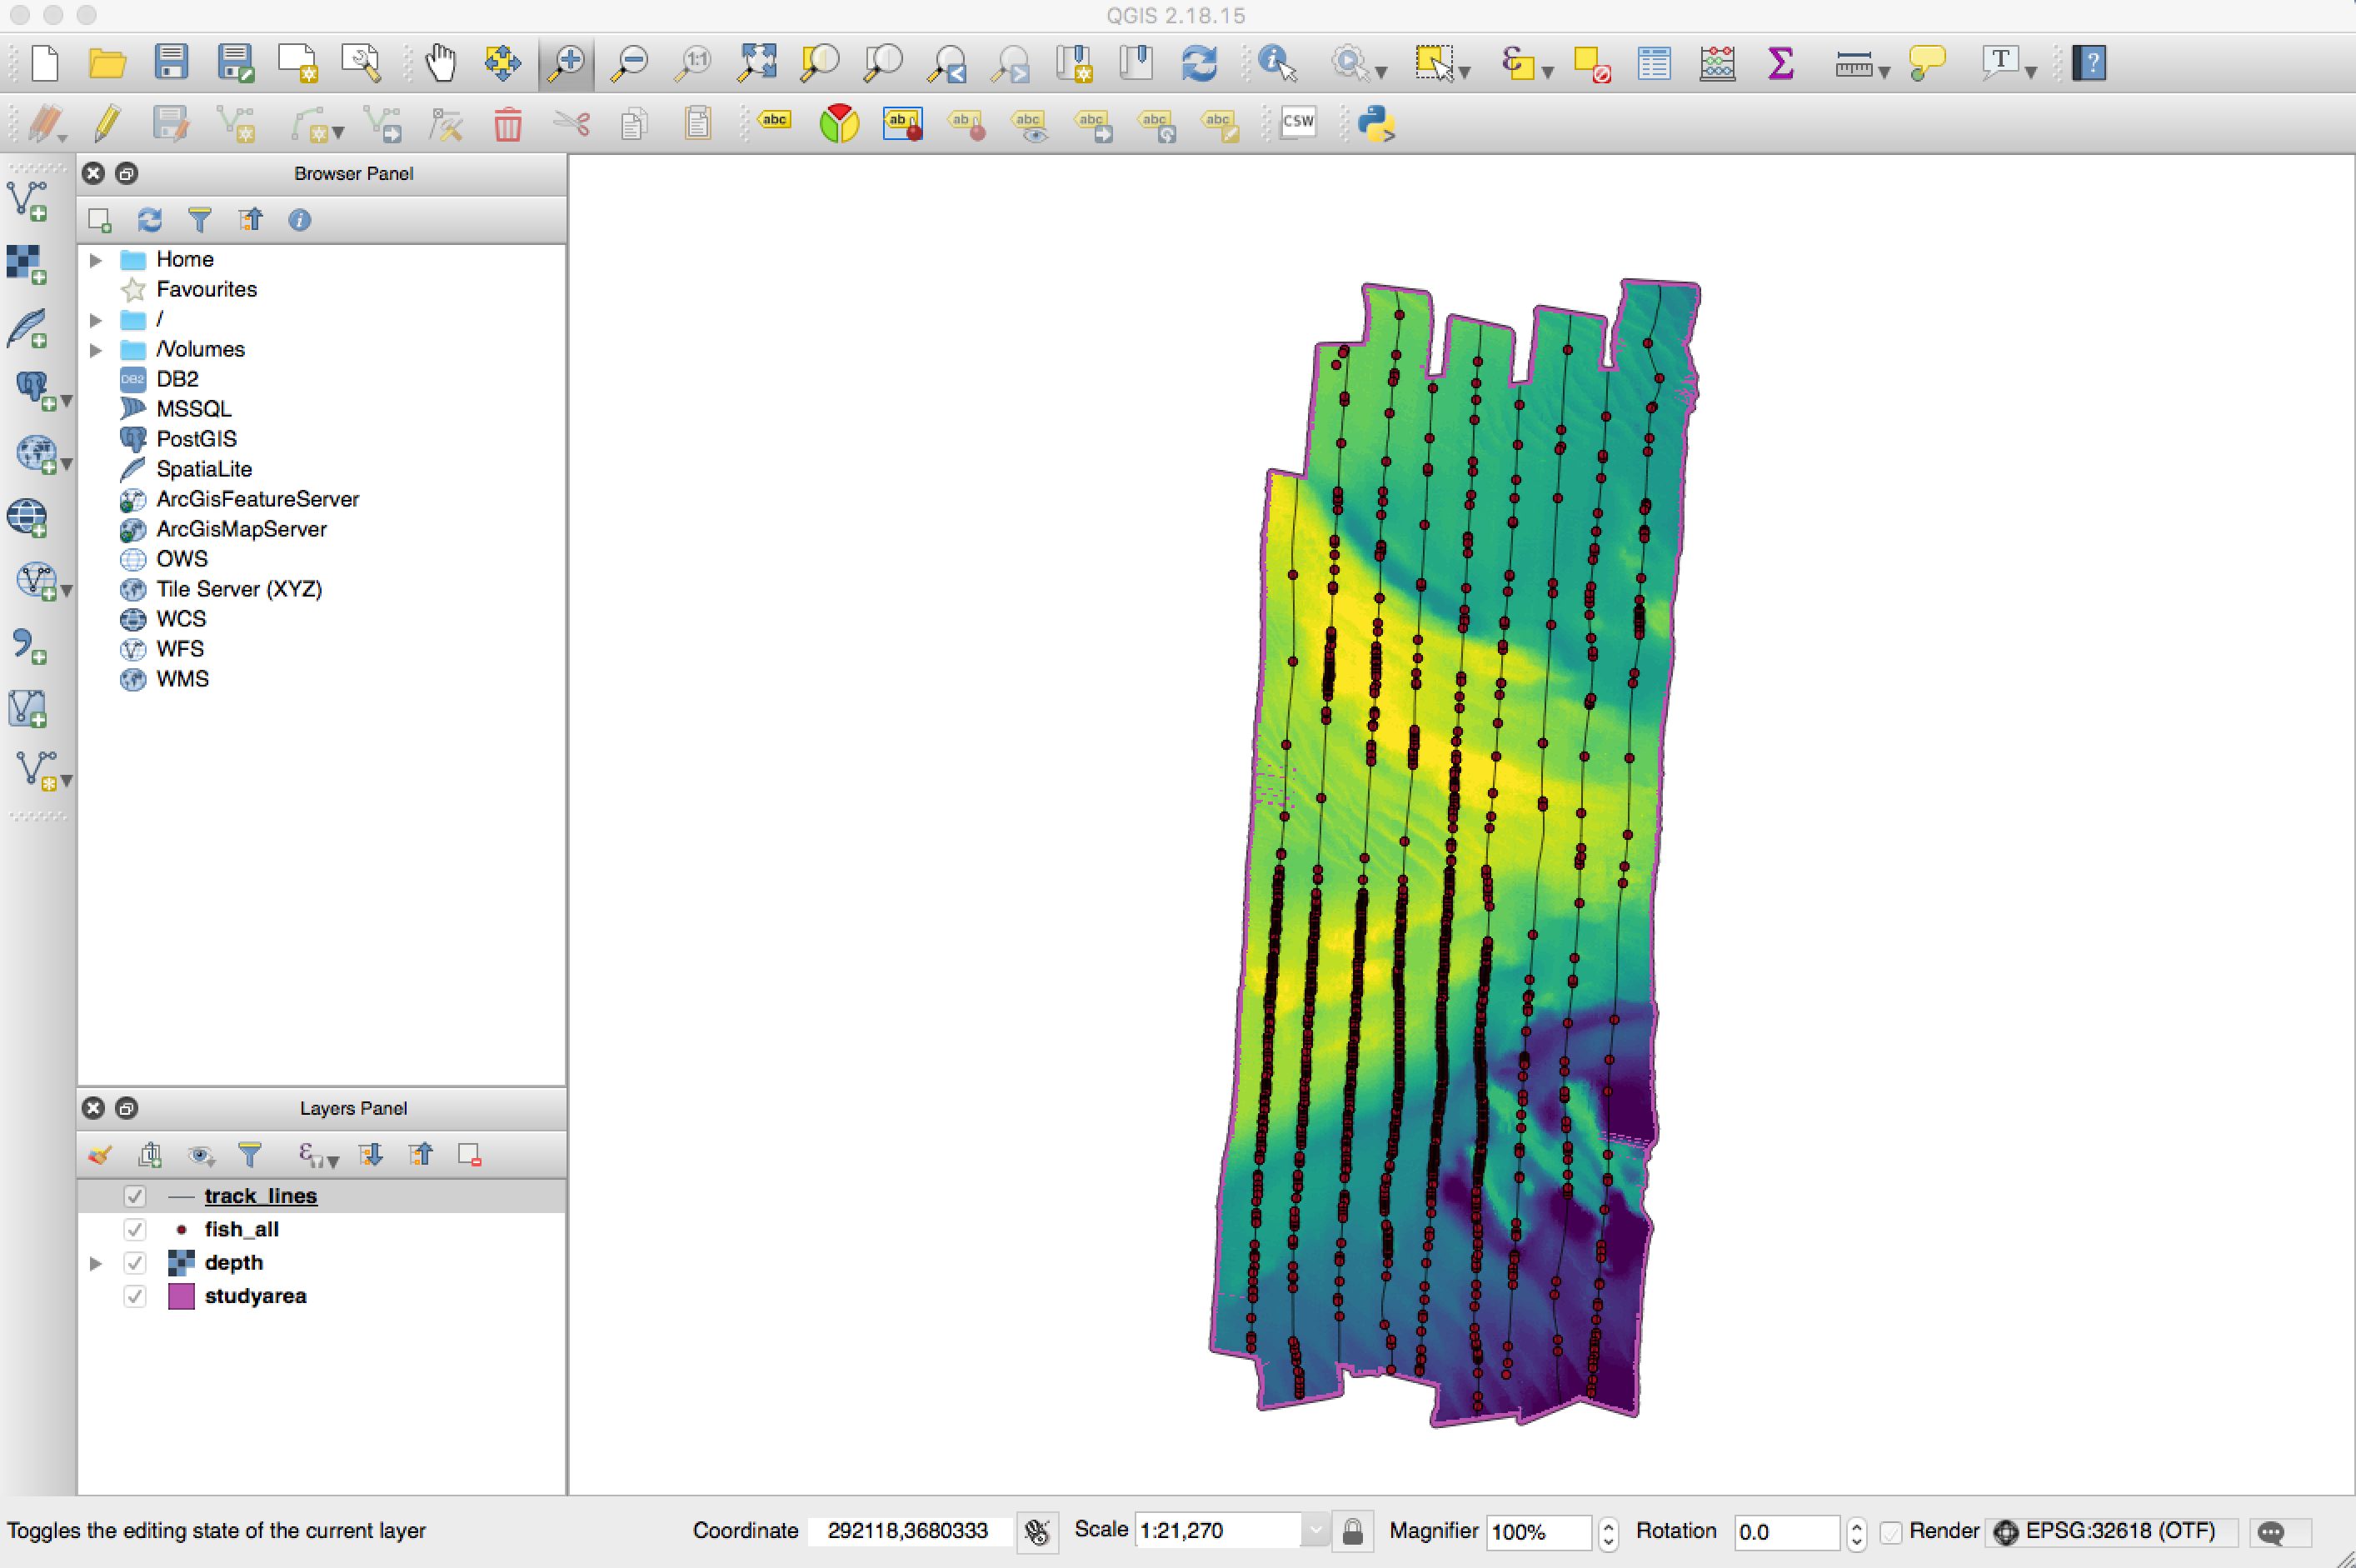

In [2]:
Image(filename='figs/qgis_image.png') 

However, I am not sure how to load these data using python tools and ensure everything lines up in the correct geospatial context.

Let's load in some data.

In [3]:
## load raster data using rasterio
depth = rasterio.open('data/depth.tif')
# backscatter = rasterio.open('data/backscatter.tif')

## load raster data using osgeo gdal
# depth = gdal.Open('data/depth.tif')
# backscatter = gdal.Open('data/backscatter.tif')
                            
## load vector data using geopandas
# fish = gpd.read_file('data/fish_all.shp')
study_area = gpd.read_file('data/study_area.shp')
# track_lines = gpd.read_file('data/track_lines.shp')

## load vector data using osgeo ogr
# driver = ogr.GetDriverByName('ESRI Shapefile')
# fish = driver.Open('data/fish_all.shp')
# study_area = driver.Open('data/study_area.shp')
# track_lines = driver.Open('data/track_lines.shp')

Now, let's say I want to do zonal rasterstats on the study area and the depth raster. How do I make sure it all lines up?

Blow I am running zonal stats using the study_area and depth raster. Seems to work.

In [4]:
zonal_depth = rs.zonal_stats(study_area, 'data/depth.tif', prefix='depth_',
                                 geojson_out=True)

zonal_depth_gdf = GeoDataFrame.from_features(zonal_depth)
zonal_depth_gdf.head(2)

,Shape_Area,Shape_Leng,depth_count,depth_max,depth_mean,depth_min,geometry
0,9.108952e+06,16677.337036,2188322,-65.0,-84.471814,-121.0,"POLYGON ((289267.6761355298 3682580.40387176, ..."


OK cool, but how can I make sure that the study_area shape file was exactly above the raster? A slight coordinate system offset could cause issues... or not?

In [5]:
## print coordinate reference system
print('Raster Coordinate Systems')
print(depth.crs)
print('\nShapefile Coordinate Systems')
print(study_area.crs)

Raster Coordinate Systems
CRS({'init': 'epsg:32618'})

Shapefile Coordinate Systems
{'init': 'epsg:26918'}


Looks like the files are in different coordinate systems... yet they plot correctly in QGIS... I tried reprojecting the shapefiles to the raster coordinate system as follows.

In [6]:
spatialRef = osr.SpatialReference()
spatialRef.ImportFromEPSG(32618)
spatialRef.MorphToESRI()

file = open('test/study_area.prj', 'w')
file.write(spatialRef.ExportToWkt())
file.close()

study_area = gpd.read_file('test/study_area.shp')

In [7]:
## print coordinate reference system
print('Raster Coordinate Systems')
print(depth.crs)
print('\nShapefile Coordinate Systems')
print(study_area.crs)

Raster Coordinate Systems
CRS({'init': 'epsg:32618'})

Shapefile Coordinate Systems
{'init': 'epsg:32618'}


However, if I open these data back up in QGIS, they don't up anymore :/ 

Not sure this reprojection is the way to go... Maybe I just need to plot the raster and vector data on the same plot to verify everything lines up? Is there a different way to go about visually / programmatically verifying that this all lines up?